---
title: "Iterated Expectations"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2023-12-1"
image: thumbnail.png
categories: ['Python', 'Probability']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [1]:
import pandas as pd
import numpy as np

I recently came across a list of [10 theorems/proofs](https://twitter.com/causalinf/status/1259448663270658050) that you "need to know" if you do econometrics. These were compiled by [Jeffrey Wooldridge](https://econ.msu.edu/faculty/wooldridge/), an economist and textbook author whose introductory textbook has been fundamental to my interest in econometrics. As an exercise, I'm working through these 10 items, compiling resources, textbook passages, and data exercises that I think can make them easier to understand. The first item I'm trying to write my notes on is the Law of Iterated Expectations, but I'll be prefacing/augmenting the notes with some discussion of basic probability for completeness.  

My core reference is [*Introduction to Probability, Second Edition*](https://projects.iq.harvard.edu/stat110/home) By Joseph K. Blitzstein, Jessica Hwang.

<hr>

To start, I'll simulate some data.

In [2]:
# Set a random seed for reproducability
np.random.seed(42)
# Define the number of people in the dataset
num_people = 100
# Generate random ages - X ~ Uniform(min, max)
ages = np.random.randint(71, 79, num_people)
# Create DataFrame
data = {'Person_ID': range(1, num_people + 1), 'Age': ages}
people_df = pd.DataFrame(data).set_index("Person_ID")

people_df.head()

,Age
Person_ID,
1,77
2,74
3,75
4,77
5,73


Let's say that these data represent life spans, thus $\text{age}_i$ is an individual's lifespan, e.g. $\text{age}_2=$

In [3]:
people_df.loc[2]

Age    74
Name: 2, dtype: int32

## Expectation
The mean of a random variable, like age above, is also referred to as its "expected value," denoted $E(\text{age})$.

In [4]:
people_df['Age'].mean()

74.6

The mean above is specifically called an *arithmetic mean*, defined as follows:  
$$ \bar{x} = \frac{1}{n} \sum_i^n x_i$$

In [5]:
(1/len(people_df)) * people_df['Age'].sum()

74.60000000000001

But the arithmetic mean is just a special case of the more general weighted mean:

\begin{align*}
\text{weighted-mean}(x) &= \sum_i^n x_i p_i \\
\end{align*}

Where the weights, $p_1, p_2, ...,p_n$ are non-negative numbers that sum to 1. We can see that the arithmetic mean is the specific case of the weighted mean where all weights are equal  

\begin{align*}
\text{If } [p_1=p_2=...=p_n] &\text{ And } [\sum_i^n p_i =1]\\
\text{weighted-mean}(x) &= \sum_i^n x_i \frac{1}{n}\\
\text{weighted-mean}(x) &= \frac{1}{n} \sum_i^n x_i = \bar{x}\\
\end{align*}

We use the more general weighted mean when we define expectation.

 >the expected value of $X$ is a weighted average of the possible values that
$X$ can take on, weighted by their probabilities  
>-- @blitzstein_introduction_2019

More formally, given a random variable, $X$, with distinct possible values, $x_1, x_2, ... x_n$, the *expected value* $E(X)$ is defined as:

\begin{align*}
E(X) = & x_1P(X = x_1) + \\
&x_2P(X = x_2) +\\
&... + x_nP(X = x_n) \\
= &\sum_{i=1}^n x_iP(X = x_i)
\end{align*}


Now we'll demonstrate this formula on our data. It's useful here to move from our individual-level dataset, where each row is a person, to the following, where each row is a lifespan, which the probability that an individual has that lifespan.

In [6]:
prob_table = people_df['Age'].value_counts(normalize=True)
prob_table = prob_table.sort_index()
prob_table

Age
71    0.08
72    0.13
73    0.11
74    0.19
75    0.12
76    0.13
77    0.13
78    0.11
Name: proportion, dtype: float64

Adapting the formula above to our data, we must solve the following:

\begin{align*}
E(\text{Age}) = &\text{Age}_1P(\text{Age}=\text{Age}_1) + \\
&\text{Age}_2P(\text{Age}=\text{Age}_2) + \\
&... + \text{Age}_nP(\text{Age}=\text{Age}_n) \\
= &\sum_{i=1}^n \text{Age}_iP(\text{Age}=\text{Age}_i)
\end{align*}

Which we can do transparently using a for-loop:

In [7]:
summation = 0
for i in range(len(prob_table)):
  summation += prob_table.index[i] * prob_table.values[i]
summation

74.60000000000001

As a quick aside -- this can also be expressed as the dot product of two vectors, where the dot product is defined as follows:  

$$
\begin{align*}
\vec{\text{Age}}\cdot P(\vec{\text{Age}}) = &\text{Age}_1P(\text{Age}=\text{Age}_1) + \\
&\text{Age}_2P(\text{Age}=\text{Age}_2) + \\
&... + \text{Age}_3P(\text{Age}=\text{Age}_3)
\end{align*}
$$

In [8]:
prob_table.index.values @ prob_table.values

74.6

Though we will stick to the summation notation paired with python for-loops for consistency

## Conditional Expectation


We often have more than one variable available to us in an analysis. Below I simulate the variable gender:

In [9]:
np.random.seed(45)
people_df['Gender'] = np.random.choice(['Female', 'Male'], len(people_df))
people_df.head()

,Age,Gender
Person_ID,,
1,77,Male
2,74,Female
3,75,Male
4,77,Female
5,73,Female


Each row in our dataset represents an individual person, and we now have access to both their gender and their life-span. It follows that we may be interested in how life-span varies across gender. In code, this entails a groupby operation, grouping on gender before calculting the mean age:

In [10]:
people_df.groupby('Gender')['Age'].mean()

Gender
Female    74.672727
Male      74.511111
Name: Age, dtype: float64

The code in this case resembles the formal notation of a conditional expectation:
$E(\text{Age} \mid \text{Gender}=\text{Gender}_j)$, where each $\text{Gender}=\text{Gender}_j$ is a distinct event.  

If we are interested specifically in the mean life-span given the event that gender is equal to male (a roundabout way of saying the average life-span for males in the data), we could calculate the following

$E(\text{Age} \mid \text{Gender}=\text{Male})$

In [11]:
people_df.groupby('Gender')['Age'].mean()['Male']

74.5111111111111

These groupby operations in `pandas` obscure some of the conceptual stuff happening inside the conditional expectation, which we'll delve deeper into now.  

So what exactly is the conditional expectation, $E(X \mid Y=y)$?  

Before answering this, it will be useful to refresh the related concept of conditional probability:  

> If $X=x$ and $Y=y$ are events with $P(Y=y)>0$, then the conditional probability of $X=x$ given $Y=y$ is denoted by $P(X=x \mid Y=y)$, defined as  
> $$ P(X=x \mid Y=y) = \frac{P(X=x , Y=y)}{P(Y=y)} $$  
>-- @blitzstein_introduction_2019

This formula specifically describes the probability of the event, $X=x$, given the *evidence*, an observed event $Y=y$.  

We want to shift to describing a mean conditional on that evidence, and we include that information via the weights in the expectation.  

>Recall that the expectation $E(X)$ is a weighted average of the possible values of $X$, where the weights are the PMF values $P(X = x)$. After learning that an event $Y=y$ occurred, we want to **use weights that have been updated to reflect this new information**.   
> 
>-- @blitzstein_introduction_2019

The key point here is that **just the weights that each $x_i$ gets multiplied by will change**, going from the probability $P(X=x)$ to the **conditional probability $P(X=x \mid Y=y)$**.

Armed with conditional probability formula above, we can define how to compute the conditional expected value
$$
\begin{align*}
E(X \mid Y=y) &= \sum_{x} x P(X=x \mid Y=y) \\
&= \sum_{x} x \frac{P(X=x , Y=y)}{P(Y=y)}
\end{align*}
$$

Returning to our example with data, we substitute terms to find the following:
$$
\begin{align*}
E(\text{Age} \mid \text{Gender}=\text{Male}) &= \sum_{i=1}^n \text{Age}_iP(\text{Age}=\text{Age}_i \mid \text{Gender}=\text{Male}) \\
&= \sum_{i=1}^n \text{Age}_i \frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Male})}{P(\text{Gender}=\text{Male})}
\end{align*}
$$


We can explicitly compute this with a for-loop in python, as we did for $E(X)$, but this time we will need to do a little up front work and define components we need for calculating the weights, $\frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Male})}{P(\text{Gender}=\text{Male})}$  

### Components
1.  The joint probability distribution: $P(\text{Age}=\text{Age}_i, \text{Gender} = \text{Male})$
2. The probability of the event, $P(\text{Gender}=\text{Male})$

Where 1.) is the following:

In [12]:
P_Age_Gender = pd.crosstab(people_df['Age'],
                           people_df['Gender'],
                           normalize='all')
P_Age_Gender['Male']

Age
71    0.03
72    0.07
73    0.05
74    0.08
75    0.07
76    0.05
77    0.06
78    0.04
Name: Male, dtype: float64

and 2.) is:

In [13]:
P_Gender = people_df['Gender'].value_counts(normalize=True)
P_Gender.loc['Male']

0.45

With those two pieces, we'll convert the following into a for-loop:
$$
\sum_{i=1}^n \text{Age}_i \frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Male})}{P(\text{Gender}=\text{Male})}
$$

In [14]:
E_age_male = 0
n = len(P_Age_Gender['Male'])
for i in range(n):
  weight = P_Age_Gender['Male'].values[i] / P_Gender.loc['Male']
  E_age_male += P_Age_Gender['Male'].index[i] * weight
E_age_male

74.51111111111112

We confirm that this is equal to the result of the more direct groupby:

In [15]:
people_df.groupby('Gender')['Age'].mean()['Male']

74.5111111111111

## The Law of Iterated Expectations

The law of iterated expectations, also referred to as the law of total expectation, the tower property, Adam's law, or, my favorite, LIE, states the following:
$$E(X) = E(E(X \mid Y))$$
Which is to say, **the weighted average of $X$ is equal to the weighted average of the weighted averages of $X$ conditional on each value of $Y$**. This isn't a particularly useful sentence, so let's return to our example data. We plug in our values as follows:
$$E(\text{Age}) = E(E(\text{Age} \mid \text{Gender}))$$
Now it is useful to break this into some components that we've seen before. We previously found
$$
E(\text{Age} \mid \text{Gender}=\text{Male}) =  \sum_{i=1}^n \text{Age}_i \frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Male})}{P(\text{Gender}=\text{Male})}
$$

Over all $\text{Gender}_j$, we have the more generalizable expression:
$$
E(\text{Age} \mid \text{Gender}=\text{Gender}_j)
$$

Which can tell us about any gender, not just $\text{Gender}=\text{Male}$. This is equivalent to the expression:

$$
\begin{align*}
E(\text{Age} \mid \text{Gender} = \text{Gender}_j) = \sum_{i=1}^n \text{Age}_i \frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j) }{P(\text{Gender}=\text{Gender}_j)}
\end{align*}
$$  

Given this, let's return to the informal definition of the LIE, but break it into parts. The weighted average of $X$ is equal to:  
1. The weighted average of
2. the weighted averages of $X$ conditional on each value of $Y$".

The expression above, $E(\text{Age} \mid \text{Gender}=\text{Gender}_j)$ is equivalent to 2.) "the weighted averages of $X$ conditional on each value of $Y$."
So what we need to do now is find the weighted average of that expression. We'll set up in the next few lines


\begin{align*}
E(\text{Age}) &=E( \underbrace{E(\text{Age} \mid \text{Gender}=\text{Gender}\_j)}_{\text{weighted averages conditional on each gender}} ) \\
&=E(\sum_{i} \text{Age}_i \frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j) }{P(\text{Gender}=\text{Gender}_j)}) \\
\end{align*}


With that set up, we'll now write out the last weighted average explicitly. Note that the variation in $\text{Age}_i$ has been accounted for -- we are now averaging over gender, $\text{Gender}_j$.

\begin{align*}
&=\sum_j (\sum_{i} \text{Age}_i \frac{P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j) }{P(\text{Gender}=\text{Gender}_j)}) P(\text{Gender}=\text{Gender}_j) \\
&=\sum_j \sum_{i} \text{Age}_i P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j) \\
\end{align*}

Since $j$ only appears in one of these two terms, we can rewrite this as follows:  

\begin{align*}
&=  \sum_{i} \text{Age}_i \sum_j P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j)
\end{align*}

Here I'll pause, because the next steps can be clarified with code. $P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j)$ is the joint probability distribution of age and gender, and it helps to take a look at exactly what it is in pandas:

In [16]:
P_Age_Gender

Gender,Female,Male
Age,,
71,0.05,0.03
72,0.06,0.07
73,0.06,0.05
74,0.11,0.08
75,0.05,0.07
76,0.08,0.05
77,0.07,0.06
78,0.07,0.04



Let's compute the summation of $P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j)$ over $\text{Gender}_j$ and see what we get.

In [17]:
P_Age_Gender["Male"] + P_Age_Gender["Female"]

Age
71    0.08
72    0.13
73    0.11
74    0.19
75    0.12
76    0.13
77    0.13
78    0.11
dtype: float64

Interestingly, that is the exact same thing we get if we simply compute the probability of each age, $P(\text{Age}=\text{Age}_i)$

In [18]:
people_df['Age'].value_counts(normalize=True).sort_index()

Age
71    0.08
72    0.13
73    0.11
74    0.19
75    0.12
76    0.13
77    0.13
78    0.11
Name: proportion, dtype: float64

So when you sum $P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j)$ only over $\text{Gender}_j$, you're just left with $P(\text{Age}=\text{Age}_i)$. This result stems from the definition of the *Marginal PMF*:  

>For the discrete random variables $X$ and $Y$, the marginal PMF of $X$ is:  
>$$P(X=x) = \sum_y P(X=x, Y=y)$$
>-- @blitzstein_introduction_2019

and with this definition in mind we can finish the proof for the LIE:
$$
\begin{align*}
E(\text{Age})  &= \sum_{i} \text{Age}_i \sum_j P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j) \\
&= \sum_{i} \text{Age}_i  P(\text{Age}=\text{Age}_i) \\
&= E(\text{Age})
\end{align*}
$$

We can directly show the last bit, $E(\text{Age}) = \sum_j \sum_{i} \text{Age}_i P(\text{Age}=\text{Age}_i, \text{Gender}=\text{Gender}_j)$ using the joint probability distribution object from before:

In [19]:
P_Age_Gender.head()

Gender,Female,Male
Age,,
71,0.05,0.03
72,0.06,0.07
73,0.06,0.05
74,0.11,0.08
75,0.05,0.07


In [20]:
(P_Age_Gender
 .sum(axis=1) # sum over j
 .reset_index() # bring out Age_i
 .product(axis=1) # Age_i * P(Age=Age_i)
 .sum() # sum over i
 )

74.6

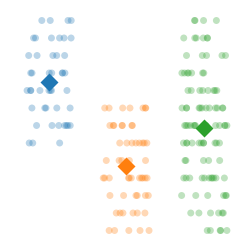

In [31]:
#| output: false
#| echo: false
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3, 3))
temp = people_df.assign(Age = people_df['Age'] + 5 * (people_df['Gender'] == 'Male'))
df = pd.concat([temp,
                temp.assign(Gender = "All")]
                )
sns.stripplot(data=df, x='Gender', y='Age', hue='Gender', alpha=.3, ax=ax, jitter = .3)
sns.pointplot(data=df, x='Gender', y='Age', hue='Gender', errorbar=None, marker="D")
# ax.set(ylim=(71, 77))
ax.set_axis_off()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)


In [22]:
people_df['Age'].mean()

74.6